In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymc3 as pm
import openpyxl as pxl
from scipy import stats
import seaborn as sb
%matplotlib inline
import theano.tensor as T
wb = pxl.load_workbook("class_data.xlsx")
wb_2f = wb["2F"]
cols = ["C", "F", "K", "P"]
np.arange(21, 51)
wb_2f["A1"].value
def cell_vals(column, lower=21, upper=51, worksheet=wb_2f):
    return [worksheet[str(column)+str(r)].value for r in np.arange(lower, upper)]
t1 = cell_vals(cols[0])
t2 = cell_vals(cols[1])
t3 = cell_vals(cols[2])
t4 = cell_vals(cols[3])

/Users/satishshankar/anaconda2/lib/python2.7/site-packages/openpyxl/workbook/names/named_range.py:121: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


# Analysis of Test Scores for Class  2F

Here is a histogram of class scores (normalized to percentages) for 2F, for all 4 terms, overlaid one over the other: 

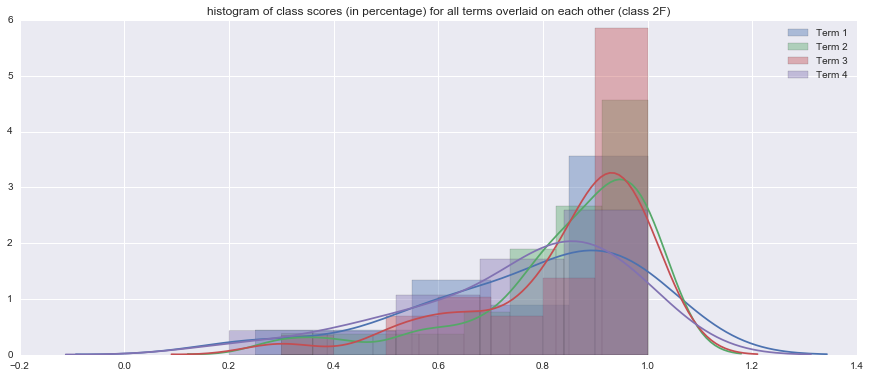

In [2]:
t1_p = [float(t)/20 for t in t1 if t is not None]
t2_p = [float(t)/20 for t in t2 if t is not None]
t3_p = [float(t)/40 for t in t3 if t is not None]
t4_p = [float(t)/50 for t in t4 if t is not None]
fig, ax = plt.subplots(figsize=(15,6))
sb.distplot(t1_p, ax=ax, label="Term 1")
sb.distplot(t2_p, ax=ax, label="Term 2")
sb.distplot(t3_p, ax=ax, label="Term 3")
sb.distplot(t4_p, ax=ax, label="Term 4")
ax.legend()
ax.set_title("histogram of class scores (in percentage) for all terms overlaid on each other (class 2F)")

Here are histograms of class scores (normalized to percentages), for each term, shown separately. With our naked eye, we see that each of terms 2, 3 and 4 have somewhat better results compared to term 1.

How can we be sure that the improvement is real, and not merely a statistical fluke? Can we quantify it? Further, can we quantify our level of statistical certainty in our results, given the data on hand? 

We are dealing with relatively small sample sizes here, and school tests are an inherently noisy measurement of student ability. For this reason, directly comparing average or median scores doesn't tell us the whole story. While it is beneficial to calculate things like confidence intervals or p-values, these methods can be quite fragile and often fail us (see http://freakonometrics.hypotheses.org/19817 and "p-hacking").

This analysis will address these subtleties in a robust manner and quantify the change in performance of the class over the year.  

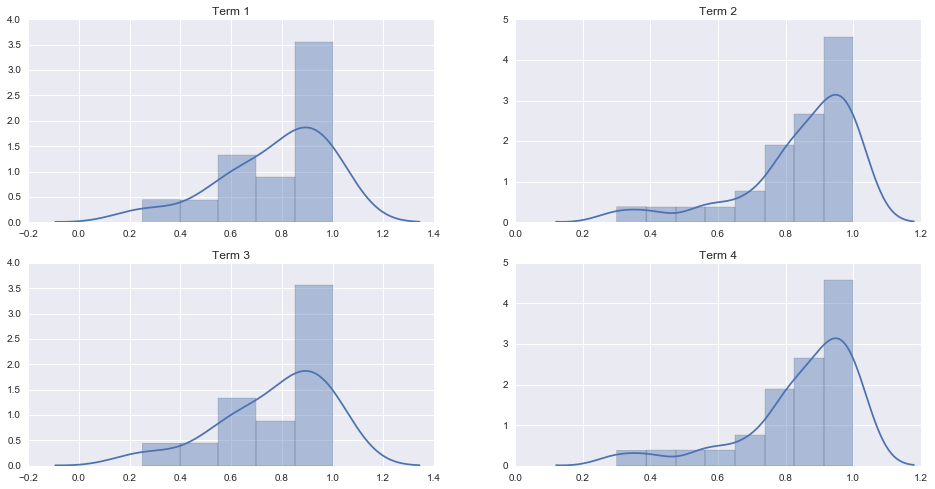

In [3]:
plt.figure(figsize=(16,8))
ax = plt.subplot(221)
sb.distplot(t1_p)
ax.set_title("Term 1")
ax = plt.subplot(222)
sb.distplot(t2_p)
ax.set_title("Term 2")
ax = plt.subplot(223)
sb.distplot(t1_p)
ax.set_title("Term 3")
ax = plt.subplot(224)
sb.distplot(t2_p)
ax.set_title("Term 4")


## A model for class performance: class performance index (CPI)

Conceptually, one can think of the class having a score that is exactly equal to the true, underlying academic ability of the class as a whole. This score is a number between 0 and 1, and let us call it the Class Performance Index (CPI). Higher the CPI, the better the class's underlying academic ability. It is impossible to directly measure CPI - instead, we will have to infer it using data from the test scores.

Below is the CPI inferred from term 1 test results. The figure shows that there is a 95% chance that the CPI lies between 0.68 and 0.83. 

For the mathematically minded, we model the class scores as if they were drawn from a Beta distribution. The CPI is the mean of the Beta distribution. We use the test results to run an MCMC sampler and infer the paramenters of the distribution. All of the code for analysis is included here.  


In [5]:
model = pm.Model()
with model:
    a = pm.Exponential("a", lam=0.25)
    b = pm.Exponential("b", lam=0.83)
    avg = pm.Deterministic("avg", a / (a+b))
    marks1 = pm.Beta("marks", alpha=a, beta=b, observed=np.array(t1_p) - 0.01)

with model:
    trace = pm.sample(25000, n_jobs=4)
    b_trace = trace[8000:]

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
100%|██████████| 25500/25500 [00:16<00:00, 1569.30it/s]


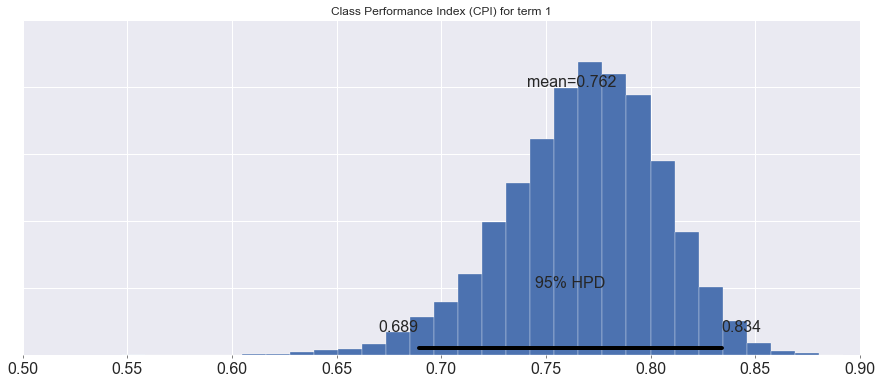

In [6]:
ax = pm.plots.plot_posterior(trace=b_trace["avg"], alpha_level=0.05, figsize=(15,6))
ax.set_title("Class Performance Index (CPI) for term 1")

Below is a distribution of the difference in class performance between term 1 and 2. Specifically, this figure shows what we can infer about CPI in term 2 - CPI in term 1, given the test scores.

From the figure, we can see that the distribution of the change is overwhelmingly positive. In fact, there is a 89.8% chance that the true, underlying academic ability (CPI) of the class increased in term 2, compared to term 1.

By how much did the CPI increase? Our best guess for the increase is 0.06. However, bear in mind that CPI (or changes to it) are not something we can every directly measure. In fact, even though our best guess for increase in CPI is 0.06, there is a 95% chance that the CPI lies in the interval between -0.03 and 0.16. The presence of this range shows the care and caution we ought to exercise while making inferences.


In [7]:
del model
model = pm.Model()
with model:
    a_pris = pm.Exponential("a", lam=0.25, shape=2, testval=4.0)
    b_pris = pm.Exponential("b", lam=0.83, shape=2, testval=1.2)
    avg_1 = pm.Deterministic("avg_1", a_pris[0] / (a_pris[0] + b_pris[0]))
    avg_2 = pm.Deterministic("avg_2", a_pris[1] / (a_pris[1] + b_pris[1]))
    delta = pm.Deterministic("delta", avg_2 - avg_1)
    marks1 = pm.Beta("marks1", alpha=a_pris[0], beta=b_pris[0], observed=np.array(t1_p) - 0.01)
    marks2 = pm.Beta("marks2", alpha=a_pris[1], beta=b_pris[1], observed=np.array(t2_p) - 0.01)
with model:
    trace = pm.sample(25000, n_jobs=4)
    b_trace = trace[8000:]
tr_21 = b_trace["delta"]

100%|██████████| 25500/25500 [00:25<00:00, 1018.32it/s]


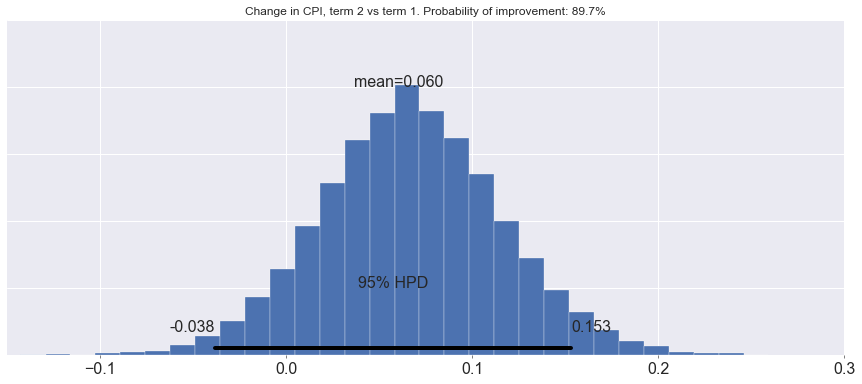

In [9]:
ax = pm.plots.plot_posterior(trace=b_trace["delta"], alpha_level=0.05, figsize=(15,6))
ax.set_title("Change in CPI, term 2 vs term 1. Probability of improvement: {}%".format(np.mean(b_trace["delta"] >= 0.0)*100))

The figure below shows the improvement in CPI in term 3, as compared to term 1. There is an 88% chance of improvement. Our single best guess for the quantity of improvement is 0.056, and there is a 95% chance that the actual change in CPI might lie in the range -0.036, 0.152.

In [10]:
del model
model = pm.Model()
with model:
    a_pris = pm.Exponential("a", lam=0.25, shape=2, testval=4.0)
    b_pris = pm.Exponential("b", lam=0.83, shape=2, testval=1.2)
    avg_1 = pm.Deterministic("avg_1", a_pris[0] / (a_pris[0] + b_pris[0]))
    avg_2 = pm.Deterministic("avg_2", a_pris[1] / (a_pris[1] + b_pris[1]))
    delta = pm.Deterministic("delta", avg_2 - avg_1)
    marks1 = pm.Beta("marks1", alpha=a_pris[0], beta=b_pris[0], observed=np.array(t1_p) - 0.01)
    marks2 = pm.Beta("marks2", alpha=a_pris[1], beta=b_pris[1], observed=np.array(t3_p) - 0.01)
with model:
    trace = pm.sample(25000, n_jobs=4)
    b_trace = trace[8000:]
tr_31 = b_trace["delta"]

100%|██████████| 25500/25500 [00:24<00:00, 1022.63it/s]


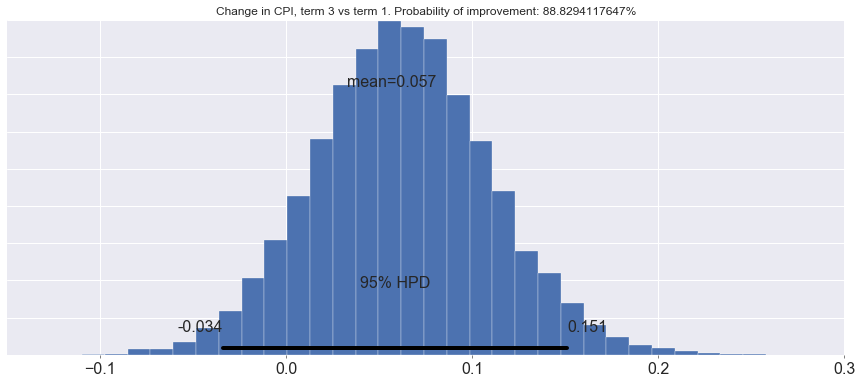

In [11]:
ax = pm.plots.plot_posterior(trace=b_trace["delta"], alpha_level=0.05, figsize=(15,6))
ax.set_title("Change in CPI, term 3 vs term 1. Probability of improvement: {}%".format(np.mean(b_trace["delta"] >= 0.0)*100))

Finally, here is a figure showing the change in CPI in term 4, compared to term 1. The probability of improvement is 33%, and there is a 95% chance that the change in CPI lies between -0.128 and 0.079. Our best guess for change in CPI is -0.021.  

In [12]:
del model
model = pm.Model()
with model:
    a_pris = pm.Exponential("a", lam=0.25, shape=2, testval=4.0)
    b_pris = pm.Exponential("b", lam=0.83, shape=2, testval=1.2)
    avg_1 = pm.Deterministic("avg_1", a_pris[0] / (a_pris[0] + b_pris[0]))
    avg_2 = pm.Deterministic("avg_2", a_pris[1] / (a_pris[1] + b_pris[1]))
    delta = pm.Deterministic("delta", avg_2 - avg_1)
    marks1 = pm.Beta("marks1", alpha=a_pris[0], beta=b_pris[0], observed=np.array(t1_p) - 0.01)
    marks2 = pm.Beta("marks2", alpha=a_pris[1], beta=b_pris[1], observed=np.array(t4_p) - 0.01)
with model:
    trace = pm.sample(25000, n_jobs=4)
    b_trace = trace[8000:]
tr_41 = b_trace["delta"]

100%|██████████| 25500/25500 [00:25<00:00, 989.70it/s]


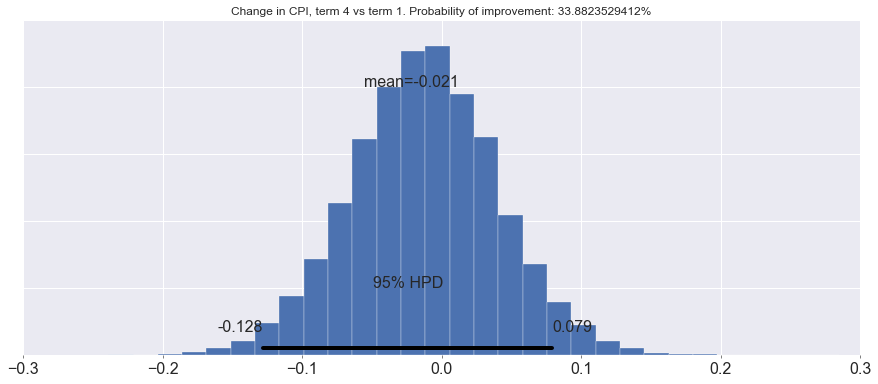

In [196]:
ax = pm.plots.plot_posterior(trace=b_trace["delta"], alpha_level=0.05, figsize=(15,6))
ax.set_title("Change in CPI, term 4 vs term 1. Probability of improvement: {}%".format(np.mean(b_trace["delta"] >= 0.0)*100))

What happens when we combine the results of term 1 + term 2 and compare them with the combined results of term 3 + term 4? 

In [199]:
r1 = np.concatenate([t1_p, t2_p])
r2 = np.concatenate([t3_p, t4_p])

In [200]:
del model
model = pm.Model()
with model:
    a_pris = pm.Exponential("a", lam=0.25, shape=2, testval=4.0)
    b_pris = pm.Exponential("b", lam=0.83, shape=2, testval=1.2)
    avg_1 = pm.Deterministic("avg_1", a_pris[0] / (a_pris[0] + b_pris[0]))
    avg_2 = pm.Deterministic("avg_2", a_pris[1] / (a_pris[1] + b_pris[1]))
    delta = pm.Deterministic("delta", avg_2 - avg_1)
    marks1 = pm.Beta("marks1", alpha=a_pris[0], beta=b_pris[0], observed=np.array(r1) - 0.01)
    marks2 = pm.Beta("marks2", alpha=a_pris[1], beta=b_pris[1], observed=np.array(r2) - 0.01)
with model:
    trace = pm.sample(25000, n_jobs=4)
    b_trace = trace[8000:]


100%|██████████| 25500/25500 [00:24<00:00, 1051.86it/s]


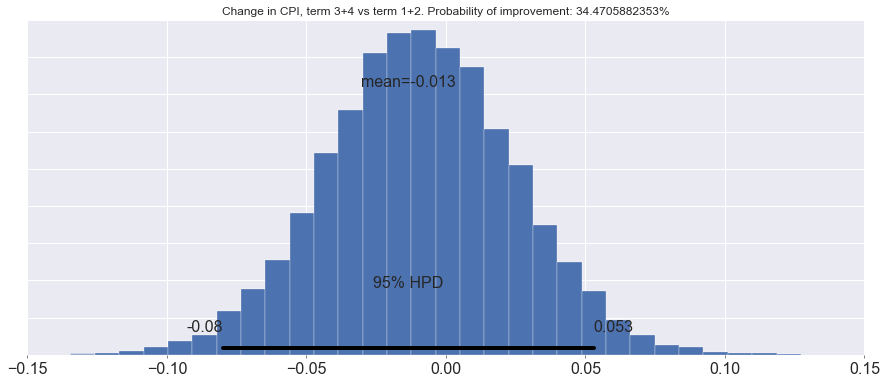

In [201]:
ax = pm.plots.plot_posterior(trace=b_trace["delta"], alpha_level=0.05, figsize=(15,6))
ax.set_title("Change in CPI, term 3+4 vs term 1+2. Probability of improvement: {}%".format(np.mean(b_trace["delta"] >= 0.0)*100))

## Conclusion

What can we conclude from all this? What is the cumulative change in CPI? Has it, over the course of the year, increased?

The figure below combines all the test results shows the cumulative change in CPI over the course of the year.

Turns out that indeed, the CPI (and hence, the underlying academic ability of the class) has experienced a positive, upward trend. In fact, there is a 70% chance that the academic abilities of the students has improved, by an average of 3.2%.

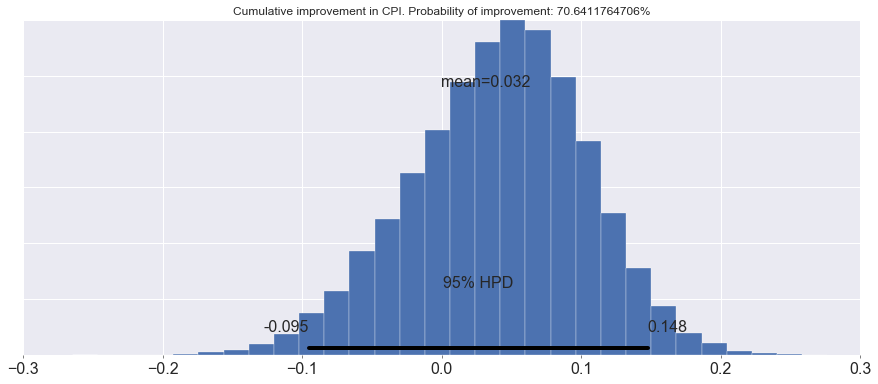

In [211]:
all_tr = np.concatenate([tr_21, tr_31, tr_41])
ax = pm.plots.plot_posterior(trace=all_tr, alpha_level=0.05, figsize=(15,6))
ax.set_title("Cumulative improvement in CPI. Probability of improvement: {}%".format(np.mean(all_tr >= 0.0)*100))